# KERAS RNN Recurrent Neuronal Networks

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Reading the Dataset

In [2]:
df = pd.read_csv('../UPDATE-TSA-NOTEBOOKS/Data/Alcohol_Sales.csv', index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.rename(columns={'S4248SM144NCEN':'Sales'},inplace=True)

In [3]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


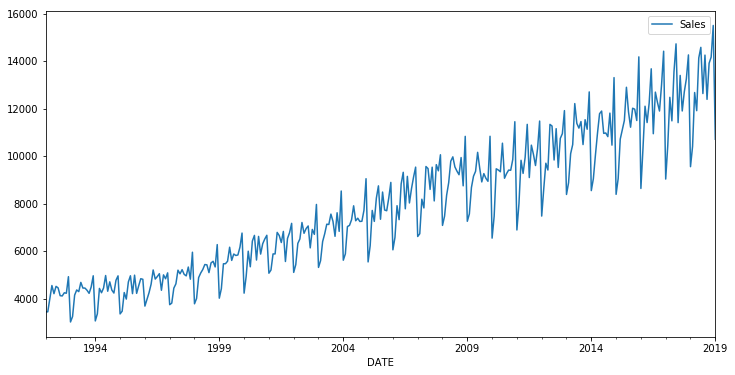

In [4]:
df.plot(figsize=(12,6));

### Error Trend Seasonality Decomposition

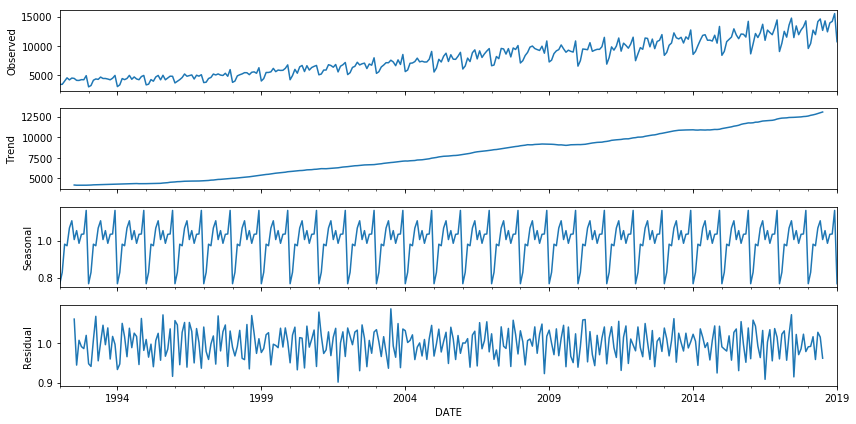

In [5]:
# model = 'additive' 'multiplicative'
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Sales'],model='mult')
from pylab import rcParams
rcParams['figure.figsize'] = 12,6
result.plot();

### Train Test Split

In [6]:
len(df)

325

In [7]:
# Let's go to forecast 12 months 
train = df.iloc[:313] # .loc[:'1940-01-01']
test = df.iloc[313:]

### Scale your Data

In [8]:
# Normalize your Data manually...There are several ways to do this
ser = np.array([23,56,2,13,14])
print('Maximum: %s'%(ser.max())) # Using sklearn it would be the fitting part
print('Scaled Data: %s'%(ser / ser.max())) # Using sklearn it would be the transforming part

Maximum: 56
Scaled Data: [0.41071429 1.         0.03571429 0.23214286 0.25      ]


In [9]:
train.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [10]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate
scaler = MinMaxScaler()
# Fit: Find the max value in the training dataset
scaler.fit(train)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 3031.000000, Max: 14730.000000


/home/eduardo/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
# normalize the dataset
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
print('Scaled Data\n',scaled_train[:5])
# inverse transform
inversed_scaled_train = scaler.inverse_transform(scaled_train)
inversed_scaled_test = scaler.inverse_transform(scaled_test)
print('\nInversed Scaled Data\n',inversed_scaled_train[:5])

Scaled Data
 [[0.03658432]
 [0.03649885]
 [0.08299855]
 [0.13103684]
 [0.1017181 ]]

Inversed Scaled Data
 [[3459.]
 [3458.]
 [4002.]
 [4564.]
 [4221.]]


### Preprocessing your Data to work with Keras TimeSeries

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [13]:
scaled_train[:5]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ]])

In [14]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [15]:
len(scaled_train)

313

In [16]:
len(train_generator)

301

In [17]:
X,y  = train_generator[0]
print('X',X)
print('y',y)

X [[[0.03658432]
  [0.03649885]
  [0.08299855]
  [0.13103684]
  [0.1017181 ]
  [0.12804513]
  [0.12266006]
  [0.09453799]
  [0.09359774]
  [0.10496624]
  [0.10334217]
  [0.16283443]]]
y [[0.]]


### Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [19]:
# units = number of neurons, activation = activation function, input_shape, input_dim es la dimensión de la entrada ya que x es un vector
# for instance we create three layers, the third one has just one nueron, because we want to solve a regression problem which give us a value in each register
model = Sequential()
# First Layer
model.add(LSTM(units=150,input_shape=(n_input,n_features),activation='relu'))
# Output Layer
model.add(Dense(units=1))
# Compile
model.compile(loss='mse',optimizer='adam')
# Summary
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fitting our Neuronal Network
# epochs really depends on how large your dataset is...and how much training data you have....
h = model.fit_generator(train_generator,epochs=100)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
301/301 [==============================] - 5s 18ms/step - loss: 0.0188
Epoch 2/100
301/301 [==============================] - 6s 19ms/step - loss: 0.0090
Epoch 3/100
301/301 [==============================] - 4s 15ms/step - loss: 0.0086
Epoch 4/100
301/301 [==============================] - 4s 15ms/step - loss: 0.0080
Epoch 5/100
301/301 [==============================] - 4s 14ms/step - loss: 0.0067
Epoch 6/100
301/301 [==============================] - 5s 16ms/step - loss: 0.0050
Epoch 7/100
301/301 [==============================] - 4s 15ms/step - loss: 0.0045
Epoch 8/100
301/301 [==============================] - 4s 14ms/step - loss: 0.0030
Epoch 9/100
301/301 [==============================] - 5s 16ms/step - loss: 0.0028
Epoch 10/100
301/301 [==============================] - 5s 16ms/step - loss: 0.0021
Epoch 11/100
301/301 [==============================] - 5s 17ms/step - loss: 0.0024
Epoch 12/100
301/301 [===============

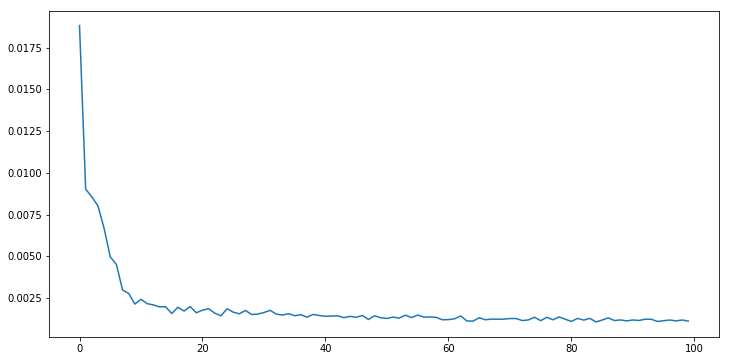

In [21]:
# Plotting loss vs epochs
loss = model.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs,loss);

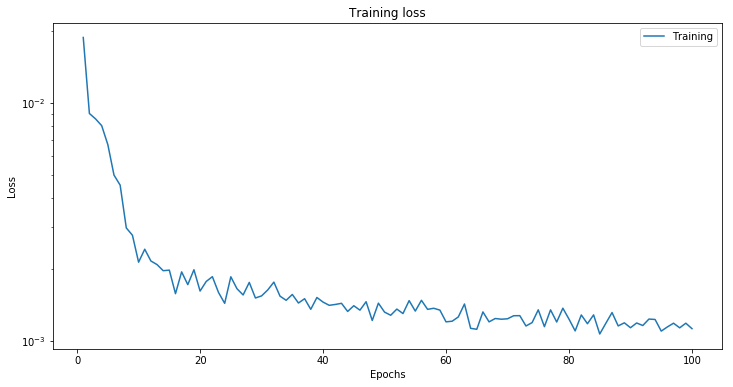

In [22]:
# Plotting loss vs epochs
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()

    plt.show()  

plot_metric(h,'loss')

In [23]:
# Our Neuronal Network will see 12 history steps and then predict step 13
# Last 12 points of Training Dataset to predict point number 1 of Testing Dataset
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [24]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [25]:
# Predict
model.predict(first_eval_batch)

array([[0.70547354]], dtype=float32)

### Predictions

In [26]:
# holding my predictions
test_predictions = []

# last n_input points from our training dataset
first_eval_batch = scaled_train[-n_input:]
# reshape this to the right format to work with RNN (same format as TTimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions
test.head()

/home/eduardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Sales,Predictions
DATE,,
2018-02-01,10415,11284.334970
2018-03-01,12683,12854.493212
2018-04-01,11919,12103.672118
2018-05-01,14138,14178.632538
2018-06-01,14583,14818.706803


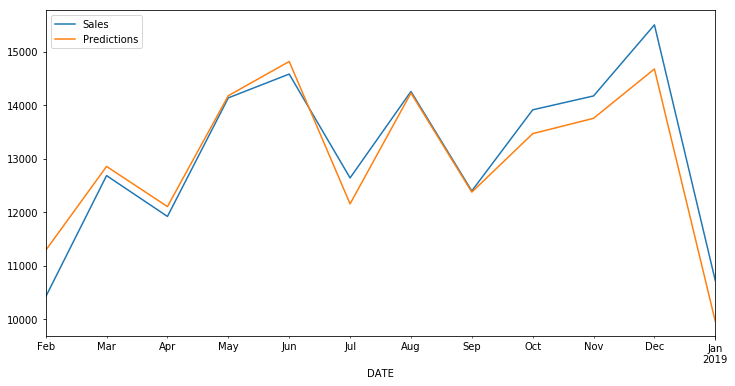

In [29]:
test.plot(figsize=(12,6));

### Evaluate the Model

In [30]:
from sklearn.metrics import mean_squared_error
RMSE = np.sqrt(mean_squared_error(test['Sales'],test['Predictions']))
RMSE

478.7720545505842

In [31]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['Sales'],test['Predictions']) # Compare it with test.mean()
error

478.7720545505842

In [32]:
test['Sales'].mean()

13111.75

### Forecast

In [37]:
from sklearn.preprocessing import MinMaxScaler
# Instantiate
scaler = MinMaxScaler()
# Fit: Find the max value in the training dataset
scaler.fit(df)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset
scaled = scaler.transform(df)

Min: 3031.000000, Max: 15504.000000


/home/eduardo/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [38]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features = 1

df_generator = TimeseriesGenerator(scaled,scaled,length=n_input,batch_size=1)

In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [40]:
# units = number of neurons, activation = activation function, input_shape, input_dim es la dimensión de la entrada ya que x es un vector
# for instance we create three layers, the third one has just one nueron, because we want to solve a regression problem which give us a value in each register
m = Sequential()
# First Layer
m.add(LSTM(units=150,input_shape=(n_input,n_features),activation='relu'))
# Output Layer
m.add(Dense(units=1))
# Compile
m.compile(loss='mse',optimizer='adam')
# Summary
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Fitting our Neuronal Network
# epochs really depends on how large your dataset is...and how much training data you have....
h = m.fit_generator(df_generator,epochs=100)

Epoch 1/100
313/313 [==============================] - 8s 26ms/step - loss: 0.0139
Epoch 2/100
313/313 [==============================] - 7s 22ms/step - loss: 0.0109
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 0.0079
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 0.0072
Epoch 5/100
313/313 [==============================] - 7s 22ms/step - loss: 0.0053
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.0042
Epoch 7/100
313/313 [==============================] - 5s 16ms/step - loss: 0.0037
Epoch 8/100
313/313 [==============================] - 5s 17ms/step - loss: 0.0027
Epoch 9/100
313/313 [==============================] - 6s 21ms/step - loss: 0.0022
Epoch 10/100
313/313 [==============================] - 5s 17ms/step - loss: 0.0019
Epoch 11/100
313/313 [==============================] - 6s 18ms/step - loss: 0.0018
Epoch 12/100
313/313 [==============================] - 6s 19ms/step - loss: 0.0017
E

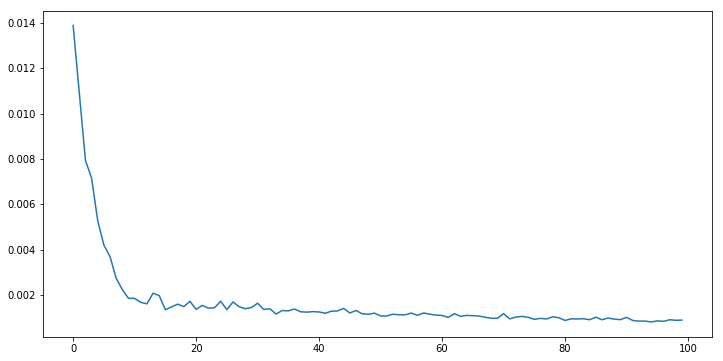

In [43]:
# Plotting loss vs epochs
loss = m.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs,loss);

### Forecast

In [45]:
# holding my forecasting values
forecast = []

# last n_input points from our training dataset
first_eval_batch = scaled[-n_input:]
# reshape this to the right format to work with RNN (same format as TTimeseriesGenerator)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# two years
for i in range(24):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = m.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [46]:
true_forecast = scaler.inverse_transform(forecast)

In [48]:
true_forecast

array([[10981.95894819],
       [12982.05907804],
       [12440.93917334],
       [14691.31462854],
       [14718.75309098],
       [13558.54335213],
       [14998.60875458],
       [12815.60611057],
       [14880.22197813],
       [14587.20950228],
       [16508.01264668],
       [10941.03135192],
       [11482.72668594],
       [13332.29852021],
       [13290.40444058],
       [15154.77387846],
       [14840.72626412],
       [14579.71702594],
       [15600.17550206],
       [13384.36223507],
       [15768.15179598],
       [15002.54234183],
       [17415.04240596],
       [11191.40704286]])

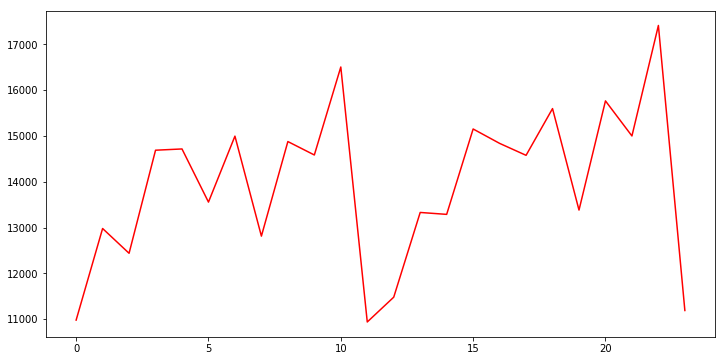

In [51]:
plt.plot(true_forecast,color='red');